<a href="https://colab.research.google.com/github/Slight-Cloud/My-LoRA-Experiments/blob/main/experiment25.11.27/lora_finetuning/BLOOM_1b7_LoRA_ChatGPT_Prompts_Fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
<h1><a href="https://github.com/peremartra/Large-Language-Model-Notebooks-Course">LLM Hands On Course</a></h1>
    <h3>Understand And Apply Large Language Models</h3>
    <h2>Introduction to LoRA Tuning using PEFT from Hugging Face.</h2>
    <h3>Fine-tune a Foundational Model effortless</h3>
    <p>by <b>Pere Martra</b></p>
</div>

<br>

<div align="center">
    &nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/pere-martra/"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>
    
</div>

<br>
<hr>

# LoRA Tuning

In this notebook I'm introducing how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

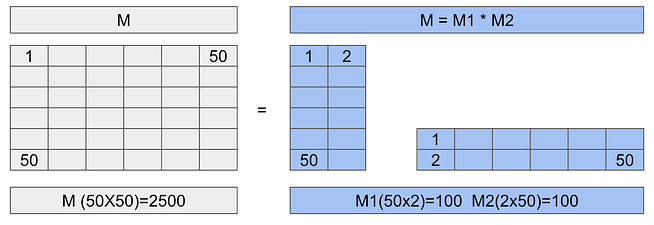

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [6]:
!python --version
!pip --version
!uname -a


Python 3.12.12
pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
Linux 779f542a19aa 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux


In [1]:
# 安装核心依赖
# -q: 安静模式，减少输出干扰
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git # 使用最新版以支持 Py3.12
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets
!pip install -q -U loralib
!pip install -q -U einops # BLOOM模型有时需要这个库

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 M

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [4]:
# 单元格 1：安装环境
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "bigscience/bloom-1b7"

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,       # 替代原来的 load_in_8bit
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,  # 新接口
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)


Loading weights:   0%|          | 0/293 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [8]:
# 单元格 3：微调前的基准测试 (Zero-shot Inference)

# 构造一个提示文本，试图引导模型生成一段关于“励志教练”的 Prompt
text = "I want you to act as a motivational coach. "
device = "cuda:0"

inputs = tokenizer(text, return_tensors="pt").to(device)

# 让原版 BLOOM 模型试着续写
with torch.no_grad(): # 推理模式，不计算梯度
    outputs = model.generate(**inputs, max_new_tokens=50)

print("Before Fine-Tuning:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Before Fine-Tuning:
I want you to act as a motivational coach.  You can help me get to the next level.
I want you to help me get to the next level.
I want you to help me get to the next level.
I want you to help me get to the next level.
I want you to


The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [9]:
# 单元格 4：加载正确的数据集
from datasets import load_dataset

# 加载 Awesome ChatGPT Prompts 数据集
data = load_dataset("fka/awesome-chatgpt-prompts")

# 查看一下数据长什么样，符合 CS 严谨性
print("数据样例:", data['train'][0])

# 数据预处理函数
def generate_prompt(data_point):
    # 构造训练格式：
    # 输入模型："I want you to act as a {角色}."
    # 期望输出："{该角色对应的详细 Prompt}"
    # 这样模型就学会了：看到“扮演X”，就输出“X的详细设定”。
    return f"{data_point['act']}: {data_point['prompt']}"

# 将处理应用到数据集，并进行 Tokenize
# 这里原 Notebook 把文本处理和 Tokenize 结合得很紧密
data = data.map(lambda samples: tokenizer(generate_prompt(samples)), batched=False)

README.md:   0%|          | 0.00/339 [00:00<?, ?B/s]

prompts.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/203 [00:00<?, ? examples/s]

数据样例: {'act': 'An Ethereum Developer', 'prompt': 'Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'}


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

# Fine-Tuning.
First is necesary create a LoRA config.


In [15]:
from peft import LoraConfig, get_peft_model, PeftModel

# 0. 防止重复注入
if isinstance(model, PeftModel):
    model.unload()

# 1. 冻结原模型参数
for param in model.parameters():
    param.requires_grad = False
    if param.ndim == 1:
        param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

# 2. LoRA 配置
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],  # Bloom 的注意力层名称
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# 3. 注入 LoRA（保证只注入一次）
model = get_peft_model(model, config)

# # 4. 打印参数
# print_trainable_parameters(model)


The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [16]:
# 单元格 6：开始训练
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    max_steps=200, # 演示用，只跑200步
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    output_dir="outputs"
)

trainer = Trainer(
    model=model,
    train_dataset=data['train'],
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
10,3.217700
20,3.168500
30,3.289700
40,3.166700
50,3.195000
60,3.272600
70,3.201000
80,3.168700
90,3.230900
100,3.193800


TrainOutput(global_step=200, training_loss=3.210226173400879, metrics={'train_runtime': 637.5094, 'train_samples_per_second': 5.02, 'train_steps_per_second': 0.314, 'total_flos': 3393381861359616.0, 'train_loss': 3.210226173400879, 'epoch': 15.392156862745098})

The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [17]:
# 定义保存路径
new_model_name = "bloom-1b7-chatgpt-prompts-lora"

# 保存 LoRA 适配器权重
# 这会在当前目录下生成一个文件夹，里面包含 adapter_model.bin 和 adapter_config.json
trainer.model.save_pretrained(new_model_name)
tokenizer.save_pretrained(new_model_name)

print(f"模型已保存至: {new_model_name}")

# 如果你想把这个模型下载到本地（可选）
# from google.colab import files
# files.download(f"{new_model_name}/adapter_model.bin")
# files.download(f"{new_model_name}/adapter_config.json")

模型已保存至: bloom-1b7-chatgpt-prompts-lora


In [21]:
# 1. 修复分词器的 Padding 问题 (关键！)
# BLOOM 默认没有 pad_token，我们将其指向 eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # 训练时通常用右侧填充

# 2. 重新定义数据处理函数 (增加截断，防止显存溢出)
def process_data(samples):
    # 构造更清晰的输入格式
    # 输入: "Act as a Linux Terminal"
    # 标签: "I want you to..."
    inputs = [f"Act as {act}.\nPrompt: {prompt}{tokenizer.eos_token}"
              for act, prompt in zip(samples['act'], samples['prompt'])]

    # 显式指定截断和最大长度，保证数据规整
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding=False)
    return model_inputs

# 3. 重新加载并处理数据
from datasets import load_dataset
data = load_dataset("fka/awesome-chatgpt-prompts")
tokenized_data = data.map(process_data, batched=True, remove_columns=data['train'].column_names)

print("数据处理修复完毕。样本示例 (Input IDs):")
print(tokenized_data['train'][0]['input_ids'][:10]) # 打印前10个token看一眼

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

数据处理修复完毕。样本示例 (Input IDs):
[8972, 661, 2246, 28857, 167625, 170786, 336, 55061, 1309, 29]


In [22]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

# 必须重新实例化 Trainer，以应用新的数据集和分词器设置
trainer = Trainer(
    model=model,
    train_dataset=tokenized_data['train'],
    args=TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=300, # 先跑300步看趋势，不用跑太久
        learning_rate=2e-4, # 稍微降低一点学习率，求稳
        fp16=True,
        logging_steps=10,
        output_dir="outputs_fixed",
        save_strategy="no", # 调试阶段先不存
    ),
    # 关键：DataCollator 会自动处理 padding，现在它知道 pad_token 是什么了
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

print("=== 开始修复后的训练 ===")
trainer.train()

=== 开始修复后的训练 ===


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
10,3.061300
20,2.635200
30,2.474300
40,2.299600
50,2.198000
60,2.138600
70,2.033900
80,1.968100
90,1.913400
100,1.755500


TrainOutput(global_step=300, training_loss=1.5459995969136555, metrics={'train_runtime': 1011.8452, 'train_samples_per_second': 4.744, 'train_steps_per_second': 0.296, 'total_flos': 5092486602915840.0, 'train_loss': 1.5459995969136555, 'epoch': 23.07843137254902})

In [23]:
import torch

# --- 第一步：保存模型到 Colab 虚拟机磁盘 ---
output_dir = "bloom-1b7-lora-chatgpt-v2"

# 保存 LoRA 适配器 (只有几MB)
trainer.model.save_pretrained(output_dir)
# 保存分词器 (方便以后直接用这个文件夹加载)
tokenizer.save_pretrained(output_dir)

print(f"✅ 模型已从显存保存到路径: ./{output_dir}")
print("   (注意：如果关闭 Colab，这个文件会丢失。需手动下载或存到 Drive)")

# --- 第二步：切换推理模式 (解决之前的报错) ---
# 1. 告诉模型我们要预测了，不是训练
model.eval()

# 2. 核心配置修复：
# 训练时为了省显存开启了 gradient_checkpointing (梯度检查点)
# 推理时为了速度需要关闭它，并开启 KV Cache
model.gradient_checkpointing_disable()
model.config.use_cache = True

print("✅ 模型配置已切换为推理模式 (Cache Enabled, Checkpointing Disabled)")

✅ 模型已从显存保存到路径: ./bloom-1b7-lora-chatgpt-v2
   (注意：如果关闭 Colab，这个文件会丢失。需手动下载或存到 Drive)
✅ 模型配置已切换为推理模式 (Cache Enabled, Checkpointing Disabled)


In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [24]:
# 定义一个通用的测试函数
def test_model(role_name, prompt_description=""):
    print(f"\n🧪 测试角色: 【{role_name}】")
    if prompt_description:
        print(f"   场景描述: {prompt_description}")

    # 构造符合训练格式的输入
    # 训练时的格式是: "Act as {role}.\nPrompt: "
    input_text = f"Act as {role_name}.\nPrompt: "

    inputs = tokenizer(input_text, return_tensors="pt")
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # 使用 autocast 解决 float16/float32 类型不匹配报错
    with torch.no_grad():
        with torch.autocast("cuda", dtype=torch.float16):
            outputs = model.generate(
                **inputs,
                max_new_tokens=150, # 生成长度
                do_sample=True,     # 采样模式，允许一点随机性
                temperature=0.7,    # 温度
                top_p=0.9,
                repetition_penalty=1.2, # 惩罚重复，防止模型复读机
                pad_token_id=tokenizer.eos_token_id
            )

    # 解码并打印
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 只提取生成部分（去掉我们的输入）
    generated_content = result.replace(input_text, "").strip()
    print(f"🤖 模型生成:\n{generated_content}")
    print("-" * 50)



In [25]:
# --- 测试开始 ---

# 测试 1: 训练集里见过的经典案例 (验证拟合能力)
# 应该能精准输出 Linux Terminal 的那个 Prompt
test_model("Linux Terminal")

# 测试 2: 也是训练集里的，验证是否学会了 "I want you to act as..." 的句式
test_model("English Translator and Improver")

# 测试 3: 泛化能力测试 (Generalization)
# 这是一个训练集里大概率没有的奇怪角色，看它能不能模仿格式自己编一个
test_model("A Drunk Mathematician", "一个喝醉的数学家")

# 测试 4: 另一个未见过的角色
test_model("Strict High School Teacher", "一个严厉的高中老师")


🧪 测试角色: 【Linux Terminal】
🤖 模型生成:
Practitioner of the Art of Unix, I want you to act like a terminal window in linux. Give me commands and it will make me an output inside one single line textbox.  Please do not provide any explanations or other symbols on your terminal. Only give us what we typed and nothing else! Do not write out history logs back into terminal for easy tracing after posting!  My first prompt is: apt-get update; apt-get install python-dev libssl-dev git-core Pythoninstaller curl --help github-scm perl -K /usr/bin/perl/kde4_perl /usr/share/pools/OpenSeaPool/usr/share/opensea-knowledge/images/dolphin-emulator-mac OS X Terminal script: vim /etc/default/gitconfig Make script? Yes
--------------------------------------------------

🧪 测试角色: 【English Translator and Improver】
🤖 模型生成:
I want you to act as an english translator, i will tell the meaning of a sentence in another language into my native langaage ,and you'll reply me back with something understandable. My first re

## Inference the fine-tuned model.

In [26]:
import shutil
from google.colab import files

# 1. 定义要打包的文件夹名称 (这是我们最后成功的那个)
folder_name = 'bloom-1b7-lora-chatgpt-v2'
output_filename = 'my_finished_model'

print(f"正在压缩 {folder_name} ...")

# 2. 压缩文件夹为 zip
shutil.make_archive(output_filename, 'zip', folder_name)

print(f"压缩完成，正在触发下载 {output_filename}.zip ...")
print("如果浏览器拦截了弹窗，请允许下载。")

# 3. 下载
files.download(f'{output_filename}.zip')

正在压缩 bloom-1b7-lora-chatgpt-v2 ...
压缩完成，正在触发下载 my_finished_model.zip ...
如果浏览器拦截了弹窗，请允许下载。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>